# Examen Segundo Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Recursos Humanos

In [2]:
df= pd.read_csv('hr_role.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

### Visualización del Dataset

In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


### Explicación de las variables

---

#### Se busca predecir si está satisfecho

In [5]:
df['is_satisfied']

0        True
1       False
2       False
3       False
4       False
        ...  
1465     True
1466    False
1467    False
1468    False
1469    False
Name: is_satisfied, Length: 1470, dtype: bool

In [6]:
target= 'is_satisfied'
y= df[target]

In [7]:
len(df[df['is_satisfied'] == 1]), len(df[df['is_satisfied'] == 0])

(459, 1011)

In [8]:
df.drop(columns=['Over18'])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,...,80,1,17,3,3,5,2,0,3,True
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,...,80,1,9,5,3,7,7,1,7,False
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,...,80,1,6,0,3,6,2,0,3,False
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,...,80,0,17,3,2,9,6,0,8,False


#### Dummies

In [9]:
df= pd.get_dummies(df)

#### NaN's

In [10]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ninguna Variable tiene NaN's , así que podemos continuar

#### Función Calibración 

In [11]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

#### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

In [12]:
X = df.copy().drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Feature Engineering

## **Modelos**

#### **KNN Clasificador**
---

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param = {
    'knn__n_neighbors': range(1, 200),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan, Euclidean
}


##### - Random Search

In [14]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param, n_iter=1000, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)


random_search.best_params_
probabilidades_knn = random_search.predict_proba(X_test)[:, 1]

print(random_search.best_params_)

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 796 is smaller than n_iter=1000. Running 796 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 77}


##### - Gridsearch

In [15]:
grid_search = GridSearchCV(pipeline, param, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search.fit(X_train, y_train)

probabilidades_knn2 = grid_search.predict_proba(X_test)[:, 1]



#### **Regresión Logística**
---

In [16]:
# Pipeline 
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
])

params_grid= {
    'poly__degree': [1, 2, 3],
    'logreg__C': ['l2', None],
    'logreg__C': [0.01,0.1,1]
}

##### RandomSearch


In [17]:
log_reg_random= RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
log_reg_random.fit(X_train, y_train)

probabilidades_logisticarandom = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

##### - Gridsearch

In [18]:
log_reg_grid= GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=5, n_jobs=-1, scoring='roc_auc')
log_reg_grid.fit(X_train, y_train)

probabilidades_logisticagrid = log_reg_grid.best_estimator_.predict_proba(X_test)[:,1]


#### **Red Neuronal**

---

In [26]:
# Pipeline
pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])

params= {
    'nn__hidden_layer_sizes': [(100,100),(100,100,100)], 
    'nn__activation':['relu', 'tanh', 'logistic'],
    'nn__alpha': [0.01,0.1,1],
}

##### - RandomSearch

In [27]:

neuro_random = RandomizedSearchCV(estimator=pipeline, param_distributions=params, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
neuro_random.fit(X_train, y_train)

probabilidades_neurorandom = neuro_random.best_estimator_.predict_proba(X_test)[:, 1]

##### - Gridsearch

In [30]:
grid_neuro= GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_neuro.fit(X_train, y_train)
probabilidades_neurogrid = grid_neuro.best_estimator_.predict_proba(X_test)[:, 1]

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### **Analisis de Discriminante Lineal**
---

In [31]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]

#### **Juntos**

In [32]:
juntos = pd.DataFrame({
     'real': y_test,     
     'probabilidades_knn': probabilidades_knn,
     'probabilidades_knn2': probabilidades_knn2,
     'logisticarandom': probabilidades_logisticarandom,
     'logisticagrid': probabilidades_logisticagrid,
     'NeuroRandom': probabilidades_neurorandom,
     'NeuroGrid': probabilidades_neurogrid,
     'probabilidades_disc': probabilidades_modelo_disc

})

juntos.head()

,real,probabilidades_knn,probabilidades_knn2,logisticarandom,logisticagrid,NeuroRandom,NeuroGrid,probabilidades_disc
515,False,0.376623,0.311765,0.467188,0.467188,0.974703,3.979094e-01,0.335046
306,False,0.363636,0.382353,0.364741,0.364741,0.001984,1.421330e-02,0.428238
1255,False,0.363636,0.376471,0.309117,0.309117,0.039357,1.159346e-01,0.329757
378,True,0.350649,0.323529,0.046688,0.046688,0.000002,9.608763e-07,0.167808
332,False,0.311688,0.323529,0.364626,0.364626,0.227111,3.100951e-03,0.358524


In [33]:
# Bins
bins = 5
juntos['bins_log1'] = pd.qcut(juntos['logisticarandom'], bins, labels=False) + 1
juntos['bins_log2'] = pd.qcut(juntos['logisticagrid'], bins, labels=False) + 1

juntos['bins_knn1'] = pd.qcut(juntos['probabilidades_knn'], bins, labels=False) + 1
juntos['bins_knn2'] = pd.qcut(juntos['probabilidades_knn2'], bins, labels=False) + 1
juntos['bins_neuralrand'] = pd.qcut(juntos['NeuroRandom'], bins, labels=False) + 1
juntos['bins_neuralgrid'] = pd.qcut(juntos['NeuroGrid'], bins, labels=False) + 1
juntos['bins_disc'] = pd.qcut(juntos['probabilidades_disc'], bins, labels=False) + 1




# Agrupaciones
grouped_log1 = juntos.groupby('bins_log1').mean()
grouped_log2 = juntos.groupby('bins_log2').mean()
grouped_knn1 = juntos.groupby('bins_knn1').mean()
grouped_knn2 = juntos.groupby('bins_knn2').mean()
grouped_neuralrand = juntos.groupby('bins_neuralrand').mean()
grouped_neuralgrid = juntos.groupby('bins_neuralgrid').mean()
grouped_disc = juntos.groupby('bins_disc').mean()


## **Histograma, Calibración, roc AUC y AUC por modelo**

#### **KNN Clasificador**
---



##### - RandomSearch

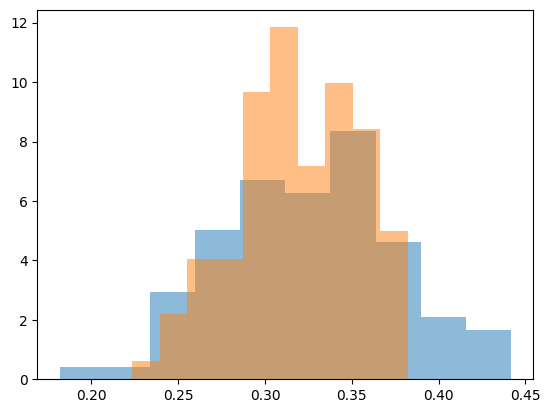

In [34]:
plt.hist(juntos[juntos.real == 1].probabilidades_knn, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_knn2, density=True, alpha=0.5, bins=10)
plt.show()

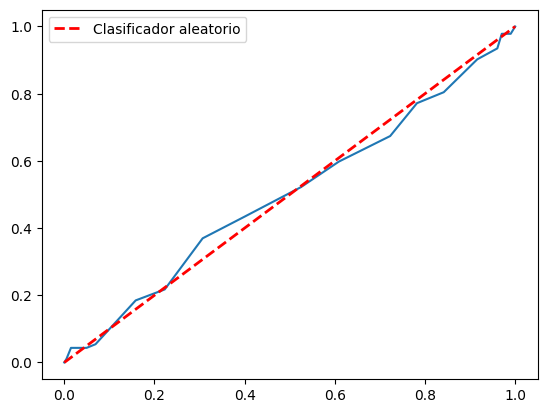

In [35]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


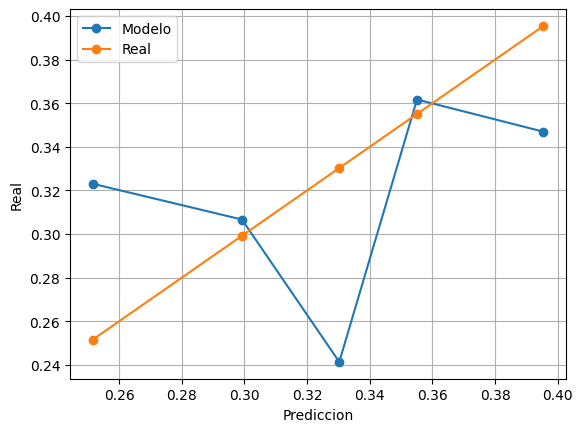

In [36]:
calibracion(probabilidades_knn, y_test, 5)

In [37]:
print('AUC RandomSearch: ',roc_auc_score(y_score= probabilidades_knn, y_true=y_test))

AUC RandomSearch:  0.5002690486439948


##### - Gridsearch

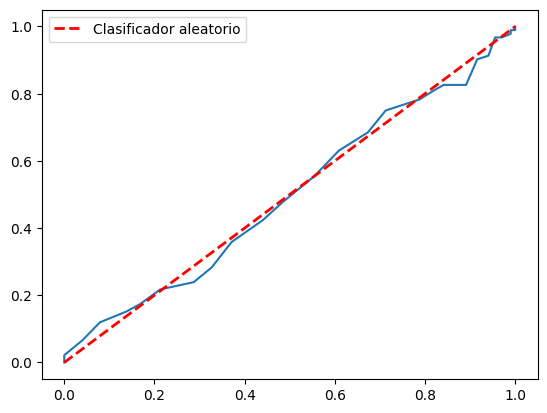

In [38]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn2, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


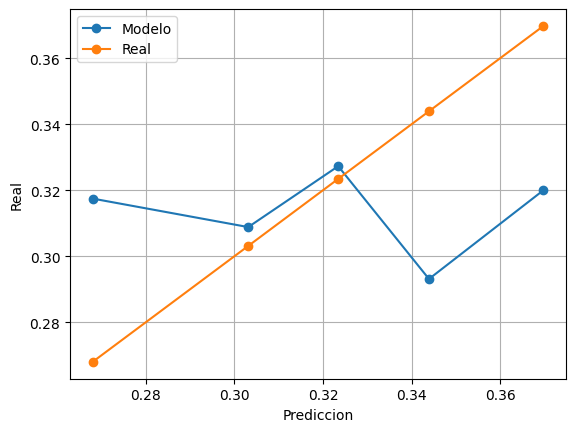

In [39]:
calibracion(probabilidades_knn2, y_test, 5)

In [40]:
print('AUC Gridsearch: ',roc_auc_score(y_score= probabilidades_knn2, y_true=y_test))

AUC Gridsearch:  0.49744403788204905


#### **Regresión Logistica**

---

##### - RandomSearch

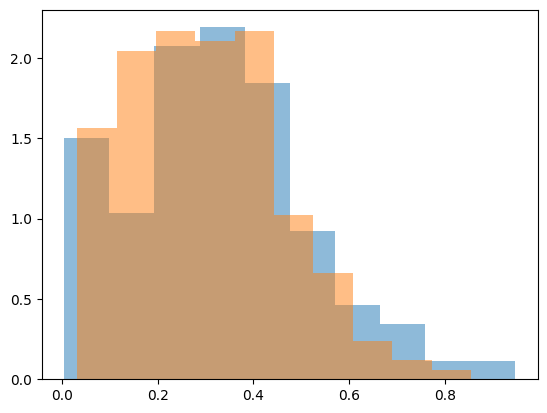

In [41]:
plt.hist(juntos[juntos.real == 1].logisticarandom, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logisticarandom, density=True, alpha=0.5, bins=10)
plt.show()

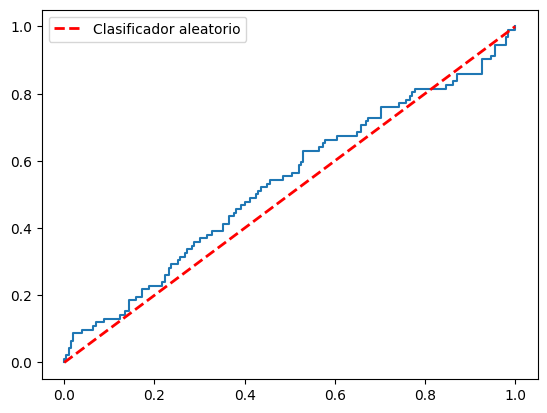

In [42]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_logisticarandom, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


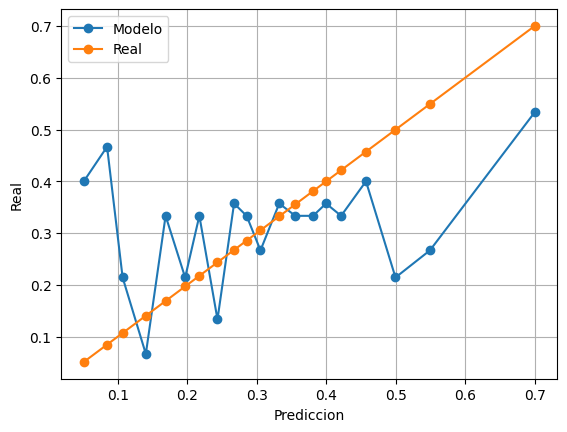

In [43]:
calibracion(probabilidades_logisticarandom, y_test, 20)

In [44]:
print('AUC: ',roc_auc_score(y_score= probabilidades_logisticarandom, y_true=y_test))

AUC:  0.534169177787344


##### - Gridsearch

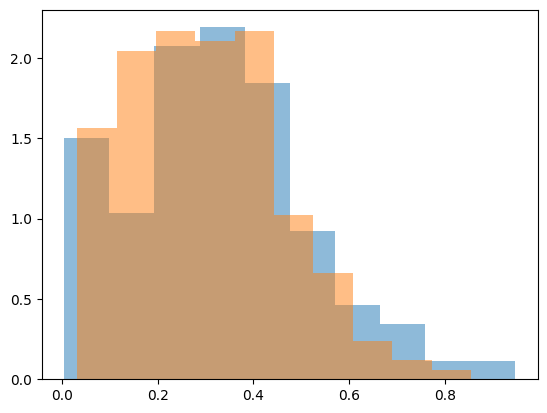

In [45]:
plt.hist(juntos[juntos.real == 1].logisticagrid, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logisticagrid, density=True, alpha=0.5, bins=10)
plt.show()

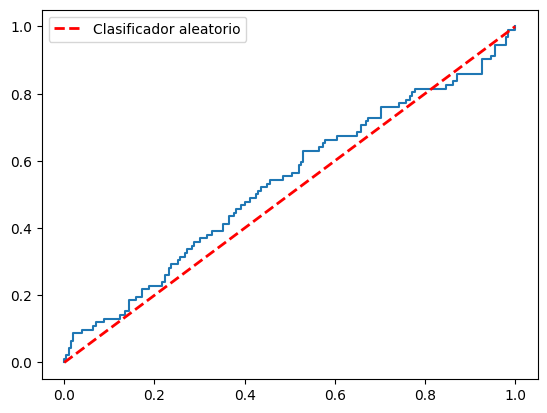

In [46]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_logisticagrid, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


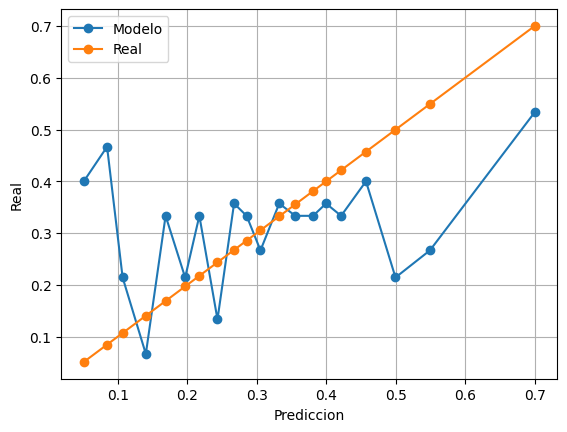

In [47]:
calibracion(probabilidades_logisticagrid, y_test, 20)

In [48]:
print('AUC: ',roc_auc_score(y_score= probabilidades_logisticagrid, y_true=y_test))

AUC:  0.534169177787344


#### **Red Neuronal**
---

##### - RandomSearch

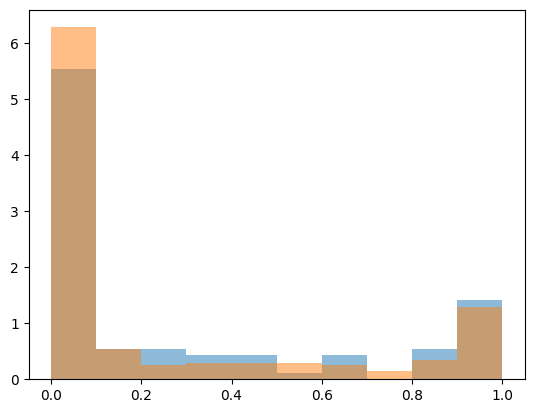

In [49]:
plt.hist(juntos[juntos.real == 1].NeuroRandom, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].NeuroRandom, density=True, alpha=0.5, bins=10)
plt.show()

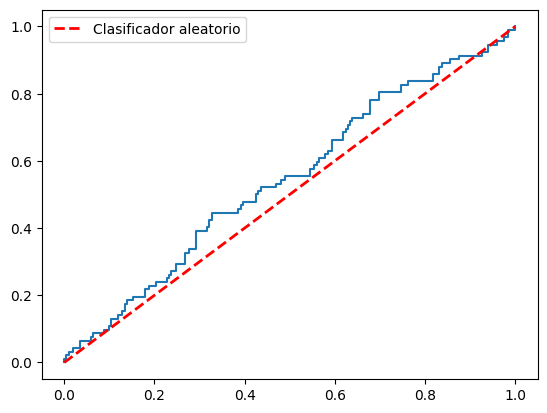

In [50]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_neurorandom, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

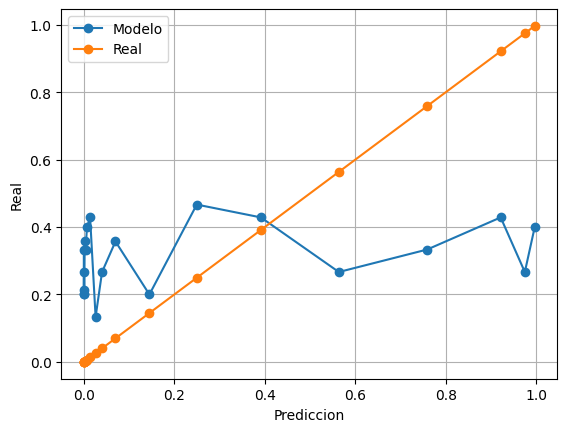

In [51]:
calibracion(probabilidades_neurorandom, y_test, 20)

In [52]:
print('AUC RandomSearch:', roc_auc_score(y_score=probabilidades_neurorandom, y_true=y_test))

AUC RandomSearch: 0.5441239776151529


##### - Gridsearch

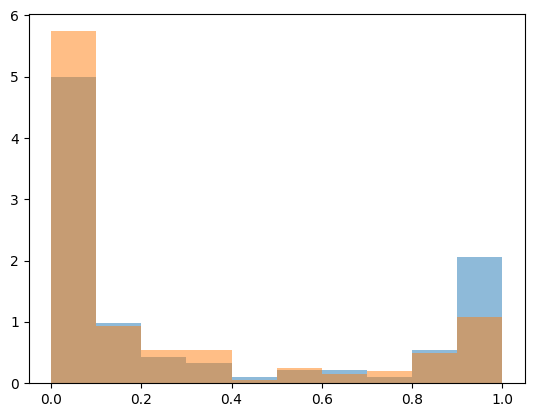

In [53]:
plt.hist(juntos[juntos.real == 1].NeuroGrid, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].NeuroGrid, density=True, alpha=0.5, bins=10)
plt.show()

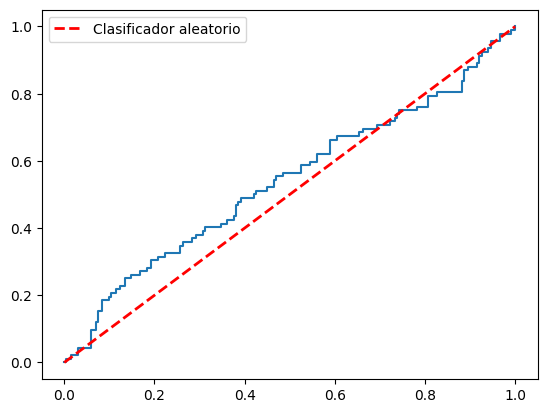

In [54]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_neurogrid, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

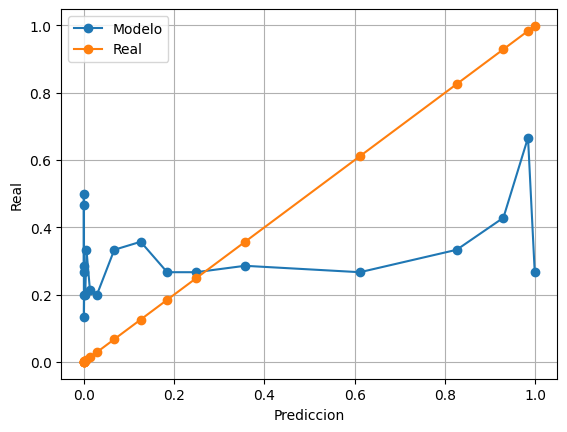

In [55]:
calibracion(probabilidades_neurogrid, y_test, 20)

In [56]:
print('AUC Gridsearch:', roc_auc_score(y_score=probabilidades_neurogrid, y_true=y_test))

AUC Gridsearch: 0.5385277658200602


##### **Discriminante Lineal**

---

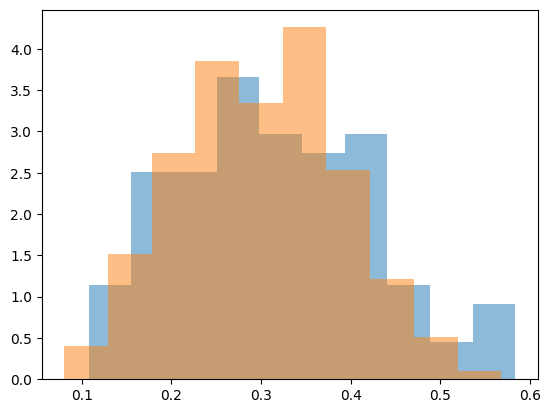

In [57]:
plt.hist(juntos[juntos.real == 1].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.show()

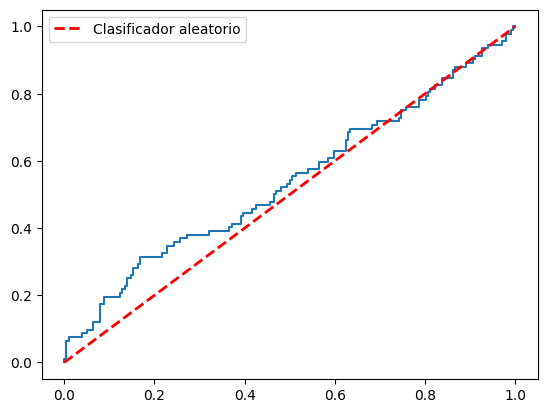

In [58]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

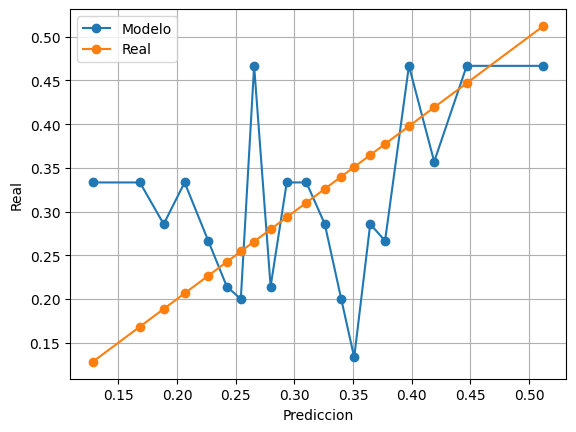

In [59]:
calibracion(probabilidades_modelo_disc, y_test, 20)

In [60]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo_disc, y_true=y_test))

AUC:  0.5391196728368489


##### Juntos

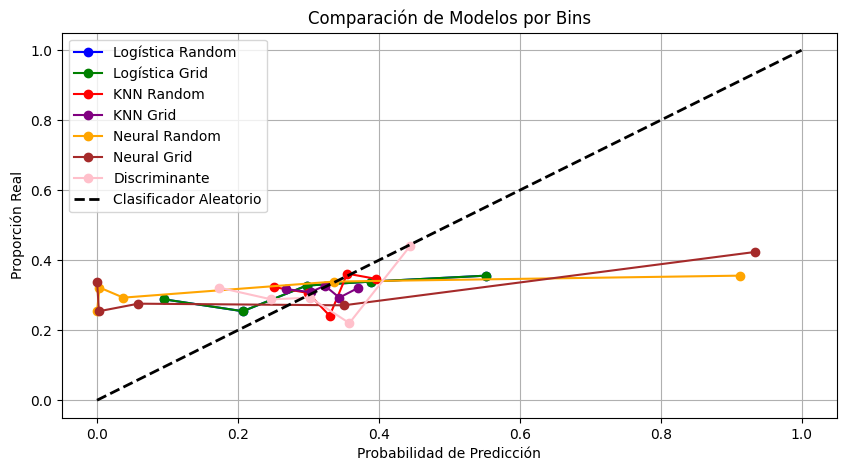

In [61]:
import matplotlib.pyplot as plt

# Definir los colores para las líneas
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'black']

# Crear la figura
plt.figure(figsize=(10, 5))

# Regresión Logística 
plt.plot(grouped_log1.logisticarandom, grouped_log1.real, marker='o', label='Logística Random', color=colors[0])
plt.plot(grouped_log2.logisticagrid, grouped_log2.real, marker='o', label='Logística Grid', color=colors[1])

# KNN
plt.plot(grouped_knn1.probabilidades_knn, grouped_knn1.real, marker='o', label='KNN Random', color=colors[2])
plt.plot(grouped_knn2.probabilidades_knn2, grouped_knn2.real, marker='o', label='KNN Grid', color=colors[3])

# Neuronal
plt.plot(grouped_neuralrand.NeuroRandom, grouped_neuralrand.real, marker='o', label='Neural Random', color=colors[4])
plt.plot(grouped_neuralgrid.NeuroGrid, grouped_neuralgrid.real, marker='o', label='Neural Grid', color=colors[5])

#Discriminante
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Discriminante', color=colors[6])

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Clasificador Aleatorio', color=colors[-1])


plt.legend()
plt.grid()
plt.xlabel('Probabilidad de Predicción')
plt.ylabel('Proporción Real')
plt.title('Comparación de Modelos por Bins')

# Mostrar el gráfico
plt.show()



## Conclusión Examen 